In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt 

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, LeakyReLU, Activation, concatenate, UpSampling2D
from keras.utils import plot_model
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
from sklearn.utils import shuffle

# import the urllib library
import urllib.request

In [ ]:
import enum 
class Interaction(enum.Enum):
    kNumuQE =0           # Numu CC QE interaction
    kNumuRes =1           # Numu CC Resonant interaction
    kNumuDIS = 2          # Numu CC DIS interaction
    kNumuOther = 3        # Numu CC, other than above
    kNueQE = 4            # Nue CC QE interaction
    kNueRes = 5           # Nue CC Resonant interaction
    kNueDIS = 6           # Nue CC DIS interaction
    kNueOther = 7         # Nue CC, other than above
    kNutauQE = 8          # Nutau CC QE interaction
    kNutauRes = 9         # Nutau CC Resonant interaction
    kNutauDIS =10         # Nutau CC DIS interaction
    kNutauOther =11       # Nutau CC, other than above
    kNuElectronElastic = 12# NC  Nu On E Scattering
    kNC =13                # NC interaction
    kCosmic =14           # Cosmic ray background
    kOther =15            # Something else.  Tau?  Hopefully we don't use this
    kNIntType=16          # Number of interaction types, used like a vector size

# **Functions**

In [ ]:
global task

def train_extractor(n_files):
  '''
  Function that extracts HDF5 data into training data and labels, depending on the task
  Inputs:
  n_files: number of files to extract data from, starts at 0
  Outputs:
  maps: xy and yz images of events for training
  labels: corresponding labels for the maps
  '''
  total_n_events = 0 # initialising events
  maps = []                    # training data
  labels = []                  # training labels
  # empty arrays 
  interactions,events,nuenergy,lepenergy = [],[],[],[]            
    
  for i in range(n_files): # looping through files
    filename = str("neutrino" + str(i+1) + ".h5") # creating filename to extract data from urllib.request
    urllib.request.urlretrieve('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/nova/' + filename, filename)
    df = h5py.File(filename,'r')
    n_events = df['cvnmap'].shape[0]
    total_n_events += n_events
    
    # extracting maps and meta data 
    cvnmaps=np.array(df['cvnmap']).reshape(n_events,100,80,2) # extracting and reshaping events in each data file
    nu_e =np.array(df['neutrino']['nuenergy'])
    lep_e =np.array(df['neutrino']['lepenergy'])
    ints = np.array(df['neutrino']['interaction'])
    
    for j in range(n_events):
      # appending each event/meta variable to empty array, so we have arrays full of all events/meta data from all files
      nuenergy.append(nu_e[j])
      lepenergy.append(lep_e[j])
      interactions.append(ints[j])
      events.append(cvnmaps[j]) # creating one array full of all events from all imported files    
  
  events=np.array(events)
  zeros_maps, zeros_labels = [], []
  ones_maps, ones_labels = [], []
  QE, DIS, RES, other, NC = [], [], [], [], []
  QE_labels, DIS_labels, RES_labels, other_labels, NC_labels = [],[],[], [], []

### numu event classifier ### 
  if task == 1:
    for j in range(total_n_events):
      if interactions[j] <= 3:
        ones_labels.append(int(1))
        ones_maps.append(events[j])
      else:
        zeros_labels.append(int(0))
        zeros_maps.append(events[j])   
    ones_labels, ones_maps = ones_labels[:len(zeros_labels)], ones_maps[:len(zeros_maps)] # cutting 1s array to the same size as 0s array
    maps = zeros_maps + ones_maps
    labels = zeros_labels + ones_labels

### neutrino energy prediction algorithm ###
  elif task == 3:
    norm = max(nuenergy)
    for j in range(total_n_events):
      maps.append(events[j]) 
      labels.append(nuenergy[j]/norm)

### interaction type classifier ###
  elif task == 4:
    for j in range(total_n_events):
      if interactions[j] <= 3:
        ones_labels.append(1)
        ones_maps.append(events[j])
      elif (interactions[j] <=7) & (interactions[j] > 3):
        zeros_labels.append(0)
        zeros_maps.append(events[j])   
    ones_labels, ones_maps = ones_labels[:len(zeros_labels)], ones_maps[:len(zeros_maps)]
    maps = zeros_maps + ones_maps
    labels = zeros_labels + ones_labels

### y = lepton/neutrino energy algorithm ###
  elif task == 5:
    for j in range(total_n_events):
      if nuenergy[j] > 0:
        maps.append(events[j]) 
        labels.append((lepenergy[j]/nuenergy[j]))

### interaction mode classifier ###
  elif task == 6:
    for j in range(total_n_events):
      if (interactions[j] == 0) or (interactions[j] == 4) or (interactions[j] == 8):
        QE.append(events[j]) # appending only QE events/labels
        QE_labels.append(4) 
      elif (interactions[j] == 1) or (interactions[j] == 5) or (interactions[j] == 9):
        RES.append(events[j]) # appending only RES events/labels
        RES_labels.append(3) 
      elif (interactions[j] == 2) or (interactions[j] == 6) or (interactions[j] == 10):
        DIS.append(events[j]) # appending only DIS events/labels
        DIS_labels.append(2)
      elif (interactions[j] == 3) or (interactions[j] == 7) or (interactions[j] == 11):
        other.append(events[j]) # appending only "other" events/labels
        other_labels.append(1)
      elif (interactions[j] == 12) or (interactions[j] == 13):
        NC.append(events[j]) # appending only NC events/labels
        NC_labels.append(0)
    
    # cutting all arrays to the same size so that the dataset has equal amounts 
    # of all intereaction modes
    QE_labels, QE = QE_labels[:len(other_labels)], QE[:len(other)]
    RES_labels, RES = RES_labels[:len(other_labels)], RES[:len(other)]
    DIS_labels, DIS = DIS_labels[:len(other_labels)], DIS[:len(other)]
    NC_labels, NC = NC_labels[:len(other_labels)], NC[:len(other)]

    maps = QE + RES + DIS + other + NC
    labels = QE_labels + RES_labels + DIS_labels + other_labels + NC_labels
      
  # shuffles the data and labels simultaneously ***without disrupting the mapping***
  maps, labels = shuffle(np.array(maps),np.array(labels)) 
  return maps, labels


In [ ]:
def test_extractor(start,n_files):
  '''
  Function that extracts HDF5 data into testing data and labels, depending on the task
  Inputs:
  start: which filenumber to start from, so as to avoid re-using train data
  n_files: number of files to extract data from
  Outputs:
  maps: xy and yz images of events for testing
  labels: corresponding labels for the maps
  '''
  total_n_events = 0 # initialising events
  # empty arrays 
  maps,labels,interactions,nuenergy,lepenergy,events,fs = [],[],[],[],[],[],[]
  files = np.arange(start, start+n_files)  

  for i in files:
    filename = str("neutrino" + str(i+1) + ".h5") # creating filename to extract data from urllib.request
    urllib.request.urlretrieve(
        'http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/nova/' + filename, 
        filename)
    df = h5py.File(filename,'r')
    n_events = df['cvnmap'].shape[0]
    total_n_events += n_events
    
    # extracting maps and meta data 
    cvnmaps=np.array(df['cvnmap']).reshape(n_events,100,80,2) # extracting and reshaping events in each data file
    finalstate =np.array(df['neutrino']['finalstate'])
    nu_e =np.array(df['neutrino']['nuenergy'])
    lep_e =np.array(df['neutrino']['lepenergy'])
    ints = np.array(df['neutrino']['interaction'])
    
    for j in range(n_events):
      # appending each event/meta variable to empty array, so we have arrays 
      # full of all events/meta data from all files
      nuenergy.append(nu_e[j])
      lepenergy.append(lep_e[j])
      interactions.append(ints[j])
      fs.append(finalstate[j])
      events.append(cvnmaps[j]) # creating one array full of all events from all 
                                # imported files    
  events=np.array(events)

  if task == 1:    # numu event classifier 
    for j in range(total_n_events):
      maps.append(events[j]) 
      labels.append(1) if interactions[j] <= 3 else labels.append(0)
      # all the metadata variables are extracted to investigate classifier efficiency (task 2)
    maps, labels, nuenergy, lepenergy,interactions,fs = np.array(maps), np.array(labels), np.array(nuenergy), np.array(lepenergy),np.array(interactions),np.array(fs)
    return maps, labels, nuenergy, lepenergy,interactions,fs
  
  elif task == 3:  # neutrino energy prediction algorithm 
    norm = max(nuenergy)
    for j in range(total_n_events):  
      maps.append(events[j]) # all events from here will be added to dataset
      labels.append(nuenergy[j]/norm) 
    return np.array(maps), np.array(labels)
    
  elif task == 4:  # interaction type classifier 
    for j in range(total_n_events):
      if interactions[j] <= 3:
        labels.append(1) # is muon neutrino event
        maps.append(events[j])
      elif (interactions[j] <=7 ) & (interactions[j] > 3):
        labels.append(0) # is electron neutrino event
        maps.append(events[j])
    maps, labels = shuffle(np.array(maps),np.array(labels))
    return maps, labels

  elif task == 5:  # y = lepton/neutrino energy algorithm 
    for j in range(total_n_events):   
      if nuenergy[j] > 0: 
        maps.append(events[j])  # all events from here will be added to dataset
        labels.append(lepenergy[j]/nuenergy[j])
    return np.array(maps), np.array(labels)

  elif task == 6:  # interaction mode classifier 
    for j in range(total_n_events):
      # QE events
      if (interactions[j] == 0) or (interactions[j] == 4) or (interactions[j] == 8):
        maps.append(events[j]) 
        labels.append(4) 
      # Res events
      elif (interactions[j] == 1) or (interactions[j] == 5) or (interactions[j] == 9):
        maps.append(events[j]) 
        labels.append(3) 
      # DIS events
      elif (interactions[j] == 2) or (interactions[j] == 6) or (interactions[j] == 10):
        maps.append(events[j]) 
        labels.append(2) 
      # "other" events
      elif (interactions[j] == 3) or (interactions[j] == 7) or (interactions[j] == 11):
        maps.append(events[j])
        labels.append(1) 
      # NC events
      elif (interactions[j] == 12) or (interactions[j] == 13):
        maps.append(events[j]) 
        labels.append(0) 
    maps, labels = shuffle(np.array(maps),np.array(labels))
    return maps, labels



In [ ]:
def feature_extractor(input_img): 
  '''
  Function to create convolutional layers to extract features from events using Keras Functional API
  Inputs:
  input_img: input shape of images to be trained using keras.layers.Input
  Outputs:
  model: model that extracts features from images
  '''
  alpha = 1e-4
  if task == 1:
    model = Conv2D(8,(2,2), activation='relu',  padding='same', input_shape=(100,80,1), 
                  kernel_regularizer = keras.regularizers.l2(alpha),
                  bias_regularizer = keras.regularizers.l2(alpha)) (input_img)
    model = MaxPooling2D(pool_size=(3,3), padding='same')(model)
    model = Dropout(0.2)(model)
    model = Conv2D(32,(2,2), activation='relu', padding='same',
                   kernel_regularizer = keras.regularizers.l2(alpha),
                   bias_regularizer = keras.regularizers.l2(alpha))(model)
    model = MaxPooling2D(pool_size=(3,3), padding='same')(model)
    model = Dropout(0.2)(model) 
    model = Conv2D(128,(2,2), activation='relu', padding='same')(model)
    model = MaxPooling2D(pool_size=(3,3), padding='same')(model)
    model = Dropout(0.4)(model)  
    model = Flatten()(model)

  else:
    model = Conv2D(32,(2,2), activation='relu', padding='same',
                   kernel_regularizer = keras.regularizers.l2(alpha),
                   bias_regularizer = keras.regularizers.l2(alpha))(input_img)
    model = MaxPooling2D(pool_size=(3,3), padding='same')(model)
    model = Dropout(0.5)(model)
    model = Conv2D(16,(2,2), activation='relu', padding='same',
                   kernel_regularizer = keras.regularizers.l2(alpha),
                   bias_regularizer = keras.regularizers.l2(alpha))(model)
    model = MaxPooling2D(pool_size=(3,3), padding='same')(model)
    model = Dropout(0.3)(model)
    model = Conv2D(2,(2,2), activation='relu', padding='same')(model)
    model = MaxPooling2D(pool_size=(3,3), padding='same')(model)
    model = Flatten()(model)
  
  return model

In [ ]:
def image_separator(img):
  '''
  Function to separate images into xz and yz components
  Inputs: image that we want to separate
  Outputs:
  xz: xz view of interaction
  yz: yz view of interaction
  '''
  xz = img[:,:,:,:1] 
  yz = img[:,:,:,1:] 

  return xz, yz

# **Inspecting the dataset**

The first thing I want to do before starting this project is analyse the quality of the data. Especially after reading many resources for this code, I found that almost always a model can never achieve desirable accuracy unless the data it is trained on is of good quality. This means there is preferably a good amount of data (at least thousands), and the data is not biased toward certain variables. 
I would like to clarify that the proportions of different variables are more or less the same for all the data files, even though below I only analyse this on one file. 


In [ ]:
urllib.request.urlretrieve('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/nova/neutrino1.h5', 
                           'neutrino1.h5')
df=h5py.File('neutrino1.h5','r')
n_events = np.array(df['cvnmap']).shape[0]
numu, nue, nutau, DIS, QE = 0,0,0,0,0
ints = df['neutrino']['interaction']
for i in range(n_events):
  if (ints[i] <= 3):
    numu +=1 
  elif (ints[i] <= 7) & (ints[i] > 3):
    nue += 1
  elif (ints[i] <= 11) & (ints[i] > 7):
    nutau +=1
  if (ints[i] == 0) or (ints[i] == 4) or (ints[i] == 8):
    QE +=1
  elif (ints[i] == 2) or (ints[i] == 6) or (ints[i] == 10):
    DIS += 1

print("muon neutrino events make up {0:0.2f}".format(100*numu/n_events), 
      "% of all events")
print("electrons neutrino events make up {0:0.2f}".format(100*nue/n_events), 
      "% of all events")
print("tau neutrino events make up {0:0.2f}".format(100*nutau/n_events), 
      "% of all events")
print("DIS events make up {0:0.2f}".format(100*DIS/n_events), 
      "% while QE events make up {0:0.2f}".format(100*QE/n_events), "%")

muon neutrino events make up 87.93 % of all events
electrons neutrino events make up 1.07 % of all events
tau neutrino events make up 0.00 % of all events
DIS events make up 54.75 % while QE events make up 12.44 %


## Unskewing the data

I compared the number of CC muon neutrino events versus the number of non-CC events, and found that there is a huge bias towards charged current events and that they make up the majority of the events in the data files, roughly 87% of all data. This means that while training the model, the data was skewed towards muon neutrino events. 

To offset this, I have created data arrays filled with a roughly equal number of CC and non-CC events, with corresponding labels, and have trained my model on that set. I did this by creating two sets of image and data arrays (one for $\nu_\mu$ CC events and one for non $\nu_\mu$ CC events) and then eliminated the excess events/labels from the array with the 1s, a process called undersampling. Then I appended the 1 and 0 label arrays and the 1 and 0 image arrays, and shuffled them using `sklearn.utils.shuffle` function, so the data would be randomly distributed without disrupting the mapping. 

In the Task 4 training data, the electron neutrinos only made up a maximum of 2% of events while muon neutrinos made up a whopping 98% of all interactions. Undersampling was employed again in the same manner as above. 

I also noted that DIS events make up over half of the data, while QE events are only ~12%. 

# **Task 1:** $\nu_\mu$ event classifier

I decided to make a binary classifier to identify $\nu_\mu$ events, with the label 1 corresponding to a $\nu_\mu$ event and a 0 corresponding to other events. In the above section, I discussed how $\nu_{\mu}$ events make up 87% of the dataset and how I used a preprocessing method called downsampling to rebalance the data.

## First step: Extracting data

I created a function to extract data from the HDF5 files called `train_extractor`. To make my code more efficient and to lessen the number of necessary functions, within this function I appended the necessary maps and labels needed for training every model, as opposed to repeating this for each task. The tasks were numbered from 1-4 and depending on the task, different values were appended to the image/label arrays.

In [ ]:
########
task = 1
########

train_images, train_labels = train_extractor(39)
xz_train, yz_train  = image_separator(train_images)

ones = 0
zeros = 0
# checking that there is an equal number of both labels
for n in train_labels:
  if n == 1:
    ones += 1
  else: 
    zeros += 1
print("The number of CC events is:", ones,
      "and the number of non-CC events is:", zeros)


The number of CC events is: 32174 and the number of non-CC events is: 32174


## Model Architecture

The Keras Functional API was used to create a dual-input CNN. A function was made called `feature_extractor()` which contains the three convolutional, pooling and dropout layers. I noticed that my network performed way better (80%+ accuracy) when I increased the number of filters layer by layer, as opposed to the standard way of building a CNN where the first layer has the most nodes (75% max accuracy). 

In [ ]:
xz_input=Input(shape=(100,80,1))
yz_input= Input(shape=(100,80,1))
xz_model = feature_extractor(xz_input) # feature extractor for xz images
yz_model = feature_extractor(yz_input) # feature extractor for yz images

conv = concatenate([xz_model, yz_model])
model = Flatten()(conv)
model = Dense(8, activation='relu')(model)
model = Dense(32, activation='relu')(model)
model = Dropout(0.3)(model)
output = Dense(1, activation='sigmoid')(model)
model = Model(inputs=[xz_input, yz_input], outputs=[output])

# summarize layers
print(model.summary())
# plot model
#plot_model(model, to_file='convolutional_neural_network.png')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100, 80, 1)] 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 100, 80, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 100, 80, 8)   40          input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 100, 80, 8)   40          input_4[0][0]                    
____________________________________________________________________________________________

In [ ]:
# compiling the first model
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                              mode = "min", 
                                              patience=5, 
                                              restore_best_weights=True)
keras.backend.clear_session()
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['binary_accuracy'])
history = model.fit([xz_train,yz_train], train_labels, epochs=70, 
                    verbose = 2, validation_split=0.2,shuffle=True, 
                    batch_size=256, callbacks=early_stop)

Epoch 1/70
202/202 - 14s - loss: 0.6063 - binary_accuracy: 0.6634 - val_loss: 0.5400 - val_binary_accuracy: 0.7347
Epoch 2/70
202/202 - 6s - loss: 0.5320 - binary_accuracy: 0.7256 - val_loss: 0.4886 - val_binary_accuracy: 0.7648
Epoch 3/70
202/202 - 6s - loss: 0.4998 - binary_accuracy: 0.7553 - val_loss: 0.4789 - val_binary_accuracy: 0.7753
Epoch 4/70
202/202 - 6s - loss: 0.4800 - binary_accuracy: 0.7708 - val_loss: 0.4884 - val_binary_accuracy: 0.7633
Epoch 5/70
202/202 - 6s - loss: 0.4716 - binary_accuracy: 0.7778 - val_loss: 0.4749 - val_binary_accuracy: 0.7836
Epoch 6/70
202/202 - 6s - loss: 0.4622 - binary_accuracy: 0.7860 - val_loss: 0.4446 - val_binary_accuracy: 0.8033
Epoch 7/70
202/202 - 6s - loss: 0.4568 - binary_accuracy: 0.7891 - val_loss: 0.4405 - val_binary_accuracy: 0.8043
Epoch 8/70
202/202 - 6s - loss: 0.4490 - binary_accuracy: 0.7940 - val_loss: 0.4917 - val_binary_accuracy: 0.7684
Epoch 9/70
202/202 - 6s - loss: 0.4470 - binary_accuracy: 0.7959 - val_loss: 0.4371 - v

Text(0.5, 1.0, 'Comparing the accuracies of the validation and trained data for a CC event classifier')

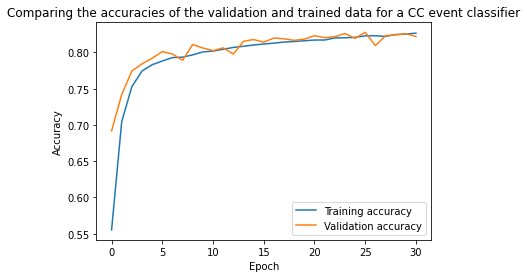

In [ ]:
# we plot the accuracies of the trained model on the same graph 
# as the test data accuracy
plt.figure()
plt.plot(history.history['binary_accuracy'], label='Training accuracy')
plt.plot(history.history['val_binary_accuracy'], label = 'Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.title("Comparing the accuracies of the validation and trained data for a CC event classifier")


Text(0.5, 1.0, 'Comparing the losses of the validation and trained data for a CC event classifier')

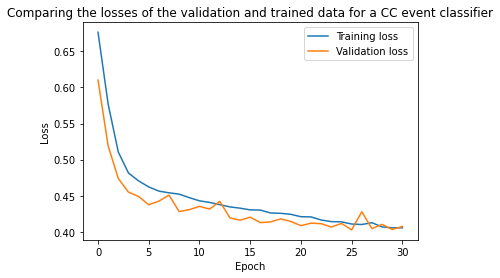

In [ ]:
plt.figure()
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.title("Comparing the losses of the validation and trained data for a CC event classifier")


## Network optimisation

## 1. Hyperparameters 

### Optimiser, metric, loss

As this is a binary classifier, the binarycrossentropy loss and binary_accuracy were employed. The optimiser 'adam' was used throughout.

### Batch size:

The batch size was chosen as 256 as the data points are in the hundreds of thousands, so processing more data in each epoch was deemed more efficient. 

### Kernel stride:

A kernel stride of (2,2) produced lower accuracy on both training/validation and on the test data than the default stride of (1,1), so it was kept to the default. 

### Callbacks

If the validation loss did not become lower by a threshold value for 5 epochs, training was stopped to limit overtraining. 

## 2. Parameters

The number of parameters was kept lower than the data points. It was noted that whenever the number of parameters was ~1,000-2,000 less than the number of data points, the training/validation accuracy shot up significantly. I thought this signified overfitting however this number of parameters consistently produced higher testing success.



In [ ]:
task = 1
test_images, test_labels, test_nuenergy, test_lepenergy,test_interactions,test_fs = test_extractor(50,1)

## Testing the model

The model was tested on a randomly chosen file; the accuracy rarely went above 80%, the loss rarely lower than 0.33. The success of the model was hard to gauge, as the same exact model run twice on the same data had a test accuracy that varied sometimes by 4-5%. For this reason I created a loop (below) to run and test the model 10 times and obtain the average test accuracy.

In [ ]:
xz_test, yz_test = image_separator(test_images)
test_acc, test_loss = model.evaluate([xz_test, yz_test], 
                                     test_labels, verbose=2)

221/221 - 1s - loss: 0.4107 - binary_accuracy: 0.7769


In [ ]:
acc = []
loss = []
for i in range(10):
  xz_input=Input(shape=(100,80,1))
  yz_input= Input(shape=(100,80,1))
  xz_model = feature_extractor(xz_input) # feature extractor for xz images
  yz_model = feature_extractor(yz_input) # feature extractor for yz images
  conv = concatenate([xz_model, yz_model])
  model = Flatten()(conv)
  model = Dense(8, activation='relu')(model)
  model = Dense(32, activation='relu')(model)
  model = Dropout(0.3)(model)
  output = Dense(1, activation='sigmoid')(model)
  model = Model(inputs=[xz_input, yz_input], outputs=[output])
  keras.backend.clear_session()
  model.compile(optimizer='adam',
                loss=tf.keras.losses.binary_crossentropy,
                metrics=['binary_accuracy'])
  history = model.fit([xz_train,yz_train], train_labels, epochs=25,
                      validation_split=0.2,shuffle=True, verbose=0, 
                      batch_size=256, callbacks=early_stop)
  test_acc, test_loss = model.evaluate([xz_test, yz_test], 
                                       test_labels, verbose=2)
  # for some reason the loss and accuracy were switched around oddly
  acc.append(test_loss)  
  loss.append(test_acc)

avg_acc, acc_error = np.mean(acc), np.std(acc)/np.sqrt(10)
avg_loss, loss_error = np.mean(loss), np.std(loss)/np.sqrt(10)

221/221 - 1s - loss: 0.4370 - binary_accuracy: 0.7239
221/221 - 1s - loss: 0.3864 - binary_accuracy: 0.7804
221/221 - 1s - loss: 0.4240 - binary_accuracy: 0.7597
221/221 - 1s - loss: 0.3723 - binary_accuracy: 0.7909
221/221 - 1s - loss: 0.3760 - binary_accuracy: 0.7884
221/221 - 1s - loss: 0.4368 - binary_accuracy: 0.7430
221/221 - 1s - loss: 0.4178 - binary_accuracy: 0.7721
221/221 - 1s - loss: 0.4456 - binary_accuracy: 0.7406
221/221 - 1s - loss: 0.3925 - binary_accuracy: 0.7704
221/221 - 1s - loss: 0.3801 - binary_accuracy: 0.7930


In [ ]:
print("the average test accuracy is {0:0.2f}".format(avg_acc) , 
      "with a standard error of {0:0.2f}".format(acc_error))
print("the average test loss is {0:0.2f}".format(avg_loss) , 
      "with a standard error of {0:0.2f}".format(loss_error))


the average test accuracy is 0.77 with a standard error of 0.01
the average test loss is 0.41 with a standard error of 0.01


## Model success

I would say this model definitely is partially successful. Ideally, a really good model would reach 90%+, but the training/validation graph definitely shows the model is indeed learning, however the lower accuracy might be linked to the quality of the data, as opposed to the model efficiency. This will be explored in task 2. 

# **Task 2:** Testing model efficiency dependence on meta variables

Below, I created 6 sub-testing sets to compare 3 metedata categories: 


1.   QE vs DIS events
2.   High lepton energy vs low lepton energy
3.   High neutrino energy vs low neutrino energy



Text(0.5, 1.0, 'Lepton energy distribution')

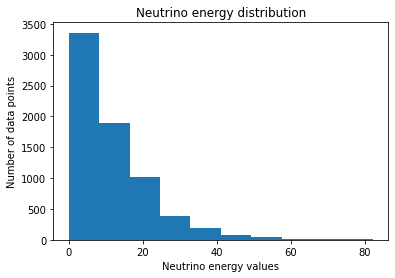

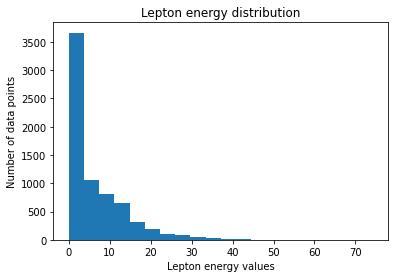

In [ ]:
nuenergy=np.array(df['neutrino']['nuenergy'])
lepenergy=np.array(df['neutrino']['lepenergy'])
plt.figure()
plt.hist(nuenergy)
plt.xlabel("Neutrino energy values")
plt.ylabel("Number of data points")
plt.title("Neutrino energy distribution")

plt.figure()
plt.hist(lepenergy,bins = 20)
plt.xlabel("Lepton energy values")
plt.ylabel("Number of data points")
plt.title("Lepton energy distribution")


## Creating test sets

I did not create a test set for RES events as I wanted to compare two ends of the spectrum (QE vs DIS). As for comparing $E_{\nu}$ values, I noticed that over 50% of the data had energy values of 16 GeV or less. To create a roughly fair split of "high" and "low" energy values, and as the highest energy was ~80 GeV, I decided to make the lower 50% of the data "low" and the other half of the data (> 16 GeV) in the "high" category. This means that the values that were 1/5 of the maximum energy value were in the low group. I did the same thing for the $E_{\ell}$ categories, where the threshold for high values was 3.8 GeV.

In [ ]:
DIS,DIS_labels = [],[]
QE,QE_labels = [],[]
highnuenergy,highnuenergy_labels = [],[]
lownuenergy,lownuenergy_labels = [],[]
highlepenergy,highlepenergy_labels = [],[]
lowlepenergy,lowlepenergy_labels = [],[]

# creating mini test sets to analyse model efficiency based on metadata
for i in range(len(test_images)):
  if (test_interactions[i] == 0) or (test_interactions[i] == 4) or (test_interactions[i] == 8):
    QE.append(test_images[i]) # appending only QE events/labels
    QE_labels.append(1) if test_interactions[i] <= 3 
    else QE_labels.append(0)

  if (test_interactions[i] == 2) or (test_interactions[i] == 6) or (test_interactions[i] == 10):
    DIS.append(test_images[i])
    DIS_labels.append(1) if test_interactions[i] <= 3 
    else DIS_labels.append(0)

  if (test_nuenergy[i] <= np.max(test_nuenergy)/5):
    lownuenergy.append(test_images[i])
    lownuenergy_labels.append(1) if test_interactions[i] <= 3 
    else lownuenergy_labels.append(0)

  else:
    highnuenergy.append(test_images[i])
    highnuenergy_labels.append(1) if test_interactions[i] <= 3 
    else highnuenergy_labels.append(0) 

  if (test_lepenergy[i] >= 3.8):
    highlepenergy.append(test_images[i])
    highlepenergy_labels.append(1) if test_interactions[i] <= 3 
    else highlepenergy_labels.append(0)

  else:
    lowlepenergy.append(test_images[i])
    lowlepenergy_labels.append(1) if test_interactions[i] <= 3 
    else lowlepenergy_labels.append(0)

QE_labels = np.array(QE_labels)
DIS_labels = np.array(DIS_labels)
highnuenergy_labels = np.array(highnuenergy_labels)
lownuenergy_labels = np.array(lownuenergy_labels)
highlepenergy_labels = np.array(highlepenergy_labels)
lowlepenergy_labels = np.array(lowlepenergy_labels)

In [ ]:
### QE ###

QE_xz, QE_yz = image_separator(np.array(QE))
test_acc, test_loss = model.evaluate([QE_xz, QE_yz], QE_labels, verbose=2)

28/28 - 0s - loss: 0.2286 - binary_accuracy: 0.8862


In [ ]:
### DIS ###

DIS_xz, DIS_yz = image_separator(np.array(DIS))
test_acc, test_loss = model.evaluate([DIS_xz, DIS_yz], 
                                     DIS_labels, verbose=2)

124/124 - 0s - loss: 0.4651 - binary_accuracy: 0.7040


In [ ]:
### high-nu energy ###

highnuenergy_xz, highnuenergy_yz = image_separator(np.array(highnuenergy))
test_acc, test_loss = model.evaluate([highnuenergy_xz, highnuenergy_yz], 
                                     highnuenergy_labels, verbose=2)

59/59 - 0s - loss: 0.3814 - binary_accuracy: 0.7698


In [ ]:
### low nu energy ### 

lownuenergy_xz, lownuenergy_yz = image_separator(np.array(lownuenergy))
test_acc, test_loss = model.evaluate([lownuenergy_xz, lownuenergy_yz], 
                                     lownuenergy_labels, verbose=2)

163/163 - 0s - loss: 0.4189 - binary_accuracy: 0.7617


In [ ]:
### high lepton energy ### 

highlepenergy_xz, highlepenergy_yz = image_separator(np.array(highlepenergy))
test_acc, test_loss = model.evaluate([highlepenergy_xz, highlepenergy_yz], 
                                     highlepenergy_labels, verbose=2)

107/107 - 0s - loss: 0.3056 - binary_accuracy: 0.8218


In [ ]:
### low lepton energy

lowlepenergy_xz, lowlepenergy_yz = image_separator(np.array(lowlepenergy))
test_acc, test_loss = model.evaluate([lowlepenergy_xz, lowlepenergy_yz], 
                                     lowlepenergy_labels, verbose=2)

115/115 - 0s - loss: 0.5048 - binary_accuracy: 0.7102


## Analysis

### QE vs. DIS events
The QE events set had much higher accuracies over several runs (87%-91%) vs DIS (63%-70%). DIS events make up over half of the dataset compared to QE which makes up only ~12% so it makes sense that the overall accuracy of the model on an unprocessed test file is closer to the DIS accuracy range.  

### High vs low neutrino energy

There was no significant difference in model performance for this variable. This is possibly due to the neutrino's characteristic low mass and therefore low impact on interactions, meaning the images would remain largely unaffected by the neutrino energy. 

### High vs low lepton energy

There was a significant difference in how the model performed for these two categories (high lepton energy was always at least 10% higher), possibly due to the fact that leptons are some of the heavier particles within these collisions (relative to neutrinos) so they can affect the interactions within the simulator. The model performed better on high lepton energy events, and as with the QE vs DIS events there is a much lower incidence of these events in the dataset, hence the lower overall accuracy. 


# **Task 3:** Neutrino energy algorithm

A regression model was created to find values for $\nu$ energies. 

In [ ]:
task = 3
train_images, train_labels = train_extractor(8)
test_images, test_labels = test_extractor(11,1)
xz_train, yz_train  = image_separator(train_images)
xz_test, yz_test = image_separator(test_images)

In [ ]:
train_labels, test_labels = np.squeeze(train_labels), np.squeeze(test_labels)
xz_input=Input(shape=(100,80,1))
yz_input= Input(shape=(100,80,1))
xz_model = feature_extractor(xz_input) # feature extractor for xz images
yz_model = feature_extractor(yz_input) # feature extractor for yz images

conv = concatenate([xz_model, yz_model])
model = Flatten()(conv)
model = Dense(42, activation='relu')(model)
model = Dense(64, activation='relu')(model)
model = Dropout(0.3)(model)
output = Dense(1, activation='sigmoid')(model)
model = Model(inputs=[xz_input, yz_input], outputs=[output])

# summarize layers
print(model.summary())
# plot model
#plot_model(model, to_file='convolutional_neural_network.png')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 80, 1)] 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 100, 80, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 80, 32)  160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 100, 80, 32)  160         input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
# compiling the first model
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                              mode = "min", patience=5, 
                                              restore_best_weights=True)
keras.backend.clear_session()
opt = tf.keras.optimizers.RMSprop()
model.compile(optimizer=opt,
              loss=tf.keras.losses.mse,
              metrics=['mse'])
history = model.fit([xz_train,yz_train], train_labels, epochs=50,
                    validation_split=0.2,shuffle=True, batch_size=256, 
                    callbacks=early_stop)

Epoch 1/50
174/174 [==============================] - 12s 63ms/step - loss: 0.0500 - mse: 0.0457 - val_loss: 0.0157 - val_mse: 0.0128
Epoch 2/50
174/174 [==============================] - 10s 60ms/step - loss: 0.0155 - mse: 0.0130 - val_loss: 0.0138 - val_mse: 0.0122
Epoch 3/50
174/174 [==============================] - 10s 60ms/step - loss: 0.0132 - mse: 0.0119 - val_loss: 0.0122 - val_mse: 0.0114
Epoch 4/50
174/174 [==============================] - 10s 60ms/step - loss: 0.0122 - mse: 0.0115 - val_loss: 0.0121 - val_mse: 0.0117
Epoch 5/50
174/174 [==============================] - 10s 60ms/step - loss: 0.0117 - mse: 0.0112 - val_loss: 0.0112 - val_mse: 0.0109
Epoch 6/50
174/174 [==============================] - 10s 60ms/step - loss: 0.0116 - mse: 0.0113 - val_loss: 0.0109 - val_mse: 0.0107
Epoch 7/50
174/174 [==============================] - 10s 60ms/step - loss: 0.0109 - mse: 0.0107 - val_loss: 0.0106 - val_mse: 0.0104
Epoch 8/50
174/174 [==============================] - 10s 60ms

Text(0.5, 1.0, 'Comparing the accuracies and losses of the validation and trained data for a CC event classifier')

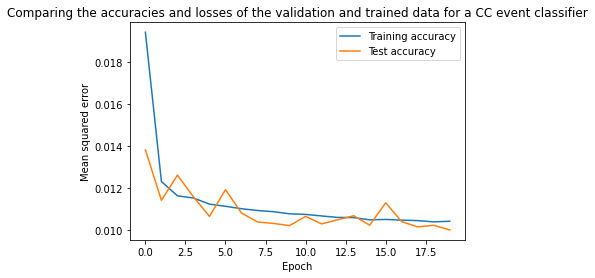

In [ ]:
# we plot the accuracies of the trained model on the same graph 
# as the test data accuracy
plt.figure()
plt.plot(history.history['mse'], label='Training accuracy')
plt.plot(history.history['val_mse'], label = 'Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Mean squared error')
plt.legend(loc='best')
plt.title("Comparing the accuracies and losses of the validation and trained data for a CC event classifier")


Text(0.5, 1.0, 'Comparing the accuracies and losses of the validation and trained data for a CC event classifier')

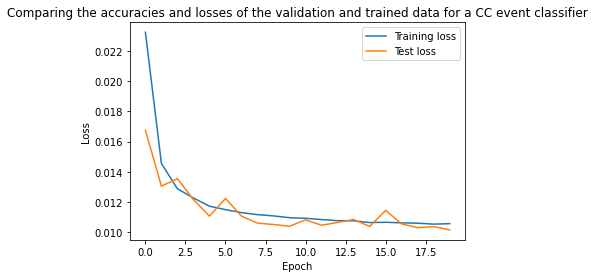

In [ ]:
plt.figure()
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.title("Comparing the accuracies and losses of the validation and trained data for a CC event classifier")


# **Task 4:**  $\nu$ flavour classifier

As was seen previously, there are no $\nu_\tau$ events in any of the data files. For my model, I did not consider interactions of type "other" to be a flavour catergory; this means that once again it will be easier to create a binary classifier to differentiate between $\nu_\mu$ and $\nu_e$ events.

### Skewed data

As with the first task, the data is also heavily skewed with electron neutrino events making up 2% of the dataset. The same downsampling process was applied to this data, too. 

In [ ]:
########
task = 4
########

train_images, train_labels = train_extractor(46)
test_images, test_labels = test_extractor(60,1)
xz_train, yz_train  = image_separator(train_images)
xz_test, yz_test = image_separator(test_images)

In [ ]:
xz_input = Input(shape=(100,80,1))
xz_model = feature_extractor(xz_input) # feature extractor for xz images
yz_input = Input(shape=(100,80,1))
yz_model = feature_extractor(yz_input) # feature extractor for yz images

conv = concatenate([xz_model, yz_model])
dense = Dense(8, activation='relu')(conv)
dense = Dense(32, activation='relu')(dense)
dense = Dropout(0.5)(dense)
output = Dense(1, activation='sigmoid')(dense)
model = Model(inputs=[xz_input, yz_input], outputs=[output])

# summarize layers
print(model.summary())
# plot model
#plot_model(model, to_file='convolutional_neural_network.png')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 80, 1)] 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 100, 80, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 80, 32)  160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 100, 80, 32)  160         input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
# compiling the model
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                              mode = "min", 
                                              patience=5, 
                                              restore_best_weights=True)
keras.backend.clear_session()
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['binary_accuracy'])
history = model.fit([xz_train,yz_train], train_labels, epochs=60,
                    validation_split=0.2,shuffle=True, batch_size=256, 
                    callbacks=early_stop)

Epoch 1/60
25/25 [==============================] - 10s 89ms/step - loss: 0.7972 - binary_accuracy: 0.5029 - val_loss: 0.6880 - val_binary_accuracy: 0.5879
Epoch 2/60
25/25 [==============================] - 1s 59ms/step - loss: 0.6959 - binary_accuracy: 0.5210 - val_loss: 0.6664 - val_binary_accuracy: 0.5999
Epoch 3/60
25/25 [==============================] - 1s 59ms/step - loss: 0.6773 - binary_accuracy: 0.5555 - val_loss: 0.6481 - val_binary_accuracy: 0.6570
Epoch 4/60
25/25 [==============================] - 1s 60ms/step - loss: 0.6637 - binary_accuracy: 0.6138 - val_loss: 0.6274 - val_binary_accuracy: 0.6960
Epoch 5/60
25/25 [==============================] - 1s 59ms/step - loss: 0.6480 - binary_accuracy: 0.6214 - val_loss: 0.6114 - val_binary_accuracy: 0.6985
Epoch 6/60
25/25 [==============================] - 1s 59ms/step - loss: 0.6250 - binary_accuracy: 0.6440 - val_loss: 0.5933 - val_binary_accuracy: 0.7054
Epoch 7/60
25/25 [==============================] - 1s 59ms/step - lo

Text(0.5, 1.0, 'Comparing the accuracies of the validation and trained data for a neutrino flavour classifier')

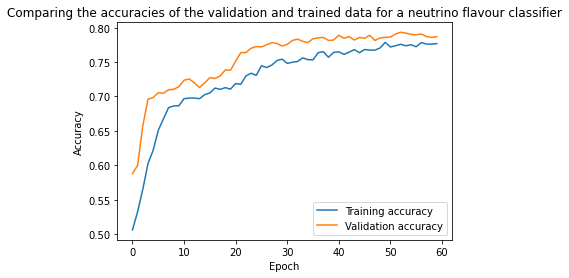

In [ ]:
# we plot the accuracies of the trained model on the same graph 
# as the test data accuracy
plt.figure()
plt.plot(history.history['binary_accuracy'], label='Training accuracy')
plt.plot(history.history['val_binary_accuracy'], label = 'Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.title("Comparing the accuracies of the validation and trained data for a neutrino flavour classifier")


Text(0.5, 1.0, 'Comparing the losses of the validation and trained data for a neutrino flavour classifier')

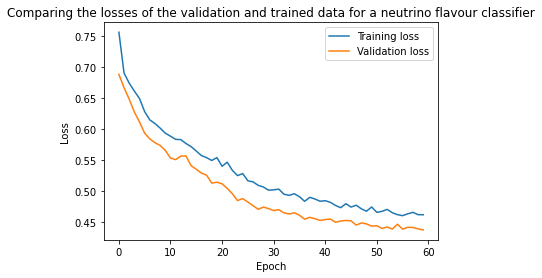

In [ ]:
plt.figure()
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.title("Comparing the losses of the validation and trained data for a neutrino flavour classifier")


In [ ]:
test_acc, test_loss = model.evaluate([xz_test, yz_test], test_labels, verbose=2)

198/198 - 1s - loss: 0.4632 - binary_accuracy: 0.6817


In [ ]:
acc = []
loss = []
for i in range(10):
  xz_input=Input(shape=(100,80,1))
  yz_input= Input(shape=(100,80,1))
  xz_model = feature_extractor(xz_input) # feature extractor for xz images
  yz_model = feature_extractor(yz_input) # feature extractor for yz images
  conv = concatenate([xz_model, yz_model])
  dense = Dense(8, activation='relu')(conv)
  dense = Dense(32, activation='relu')(dense)
  dense = Dropout(0.5)(dense)
  output = Dense(1, activation='sigmoid')(dense)
  model = Model(inputs=[xz_input, yz_input], outputs=[output])
  keras.backend.clear_session()
  model.compile(optimizer='adam',
                loss=tf.keras.losses.binary_crossentropy,
                metrics=['binary_accuracy'])
  history = model.fit([xz_train,yz_train], train_labels, epochs=20,
                      validation_split=0.2,shuffle=True, verbose=0, 
                      batch_size=256, callbacks=early_stop)
  test_acc, test_loss = model.evaluate([xz_test, yz_test], 
                                       test_labels, verbose=2)
  acc.append(test_acc)
  loss.append(test_loss)



198/198 - 1s - loss: 0.4281 - binary_accuracy: 0.8612
198/198 - 1s - loss: 0.5006 - binary_accuracy: 0.8618
198/198 - 1s - loss: 0.3776 - binary_accuracy: 0.9290
198/198 - 1s - loss: 0.4886 - binary_accuracy: 0.9285
198/198 - 1s - loss: 0.4507 - binary_accuracy: 0.9149
198/198 - 1s - loss: 0.5408 - binary_accuracy: 0.8919
198/198 - 1s - loss: 0.4960 - binary_accuracy: 0.8822
198/198 - 1s - loss: 0.4102 - binary_accuracy: 0.8852
198/198 - 1s - loss: 0.4592 - binary_accuracy: 0.8941
198/198 - 1s - loss: 0.4588 - binary_accuracy: 0.9003


In [ ]:
avg_acc, acc_error = np.mean(loss), np.std(loss)/np.sqrt(10)
avg_loss, loss_error = np.mean(acc), np.std(acc)/np.sqrt(10)
print("the average test accuracy is {0:0.2f}".format(avg_acc) , 
      "with a standard error of {0:0.2f}".format(acc_error))
print("the average test loss is {0:0.2f}".format(avg_loss) , 
      "with a standard error of {0:0.2f}".format(loss_error))


the average test accuracy is 0.89 with a standard error of 0.01
the average test loss is 0.46 with a standard error of 0.01


This was the most successful model on the testing set. 

# **Task 5:** $y = E_{\ell} /E_{\nu} $ algorithm

A regression model was created to find values for the ratio of neutrino and lepton energies. 
In this dataset, any data points with $E_{\nu} = 0$ were discarded to avoid dividing by 0.

In [ ]:
task = 5
train_images, train_labels = train_extractor(7)
test_images, test_labels = test_extractor(11,2)
xz_train, yz_train  = image_separator(train_images)
xz_test, yz_test = image_separator(test_images)

In [ ]:
train_labels,test_labels = np.squeeze(train_labels),np.squeeze(test_labels)
xz_input=Input(shape=(100,80,1))
yz_input= Input(shape=(100,80,1))
xz_model = feature_extractor(xz_input) # feature extractor for xz images
yz_model = feature_extractor(yz_input) # feature extractor for yz images

conv = concatenate([xz_model, yz_model])
model = Flatten()(conv)
model = Dense(48, activation='relu')(model)
model = Dense(64, activation='relu')(model)
model = Dropout(0.3)(model)
output = Dense(1, activation='sigmoid')(model)
model = Model(inputs=[xz_input, yz_input], outputs=[output])

# summarize layers
print(model.summary())
# plot model
#plot_model(model, to_file='convolutional_neural_network.png')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 80, 1)] 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 100, 80, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 80, 32)  160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 100, 80, 32)  160         input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
# compiling the model
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                              mode = "min", patience=5, 
                                              restore_best_weights=True)
keras.backend.clear_session()
opt = tf.keras.optimizers.RMSprop()
model.compile(optimizer=opt,
              loss=tf.keras.losses.mse,
              metrics=['mse'])
history = model.fit([xz_train,yz_train], train_labels, epochs=60,
                    validation_split=0.2,shuffle=True, batch_size=256, 
                    callbacks=early_stop)

Epoch 1/60
151/151 [==============================] - 11s 63ms/step - loss: 0.0755 - mse: 0.0714 - val_loss: 0.0583 - val_mse: 0.0548
Epoch 2/60
151/151 [==============================] - 9s 59ms/step - loss: 0.0581 - mse: 0.0548 - val_loss: 0.0560 - val_mse: 0.0531
Epoch 3/60
151/151 [==============================] - 9s 59ms/step - loss: 0.0561 - mse: 0.0533 - val_loss: 0.0540 - val_mse: 0.0516
Epoch 4/60
151/151 [==============================] - 9s 60ms/step - loss: 0.0542 - mse: 0.0518 - val_loss: 0.0530 - val_mse: 0.0509
Epoch 5/60
151/151 [==============================] - 9s 60ms/step - loss: 0.0527 - mse: 0.0507 - val_loss: 0.0526 - val_mse: 0.0508
Epoch 6/60
151/151 [==============================] - 9s 59ms/step - loss: 0.0527 - mse: 0.0510 - val_loss: 0.0509 - val_mse: 0.0493
Epoch 7/60
151/151 [==============================] - 9s 59ms/step - loss: 0.0512 - mse: 0.0497 - val_loss: 0.0533 - val_mse: 0.0520
Epoch 8/60
151/151 [==============================] - 9s 59ms/step -

Text(0.5, 1.0, 'Comparing the accuracies of the validation and trained data for regression model')

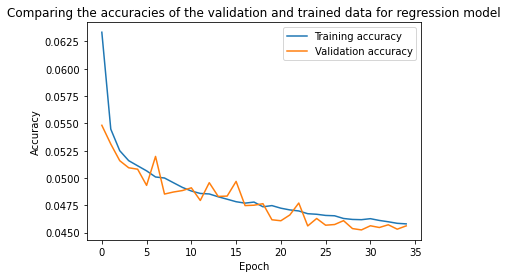

In [ ]:
# we plot the accuracies of the trained model on the same graph as the test data accuracy
plt.figure()
plt.plot(history.history['mse'], label='Training accuracy')
plt.plot(history.history['val_mse'], label = 'Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.title("Comparing the accuracies of the validation and trained data for regression model")


Text(0.5, 1.0, 'Comparing the losses of the validation and trained data for regression model')

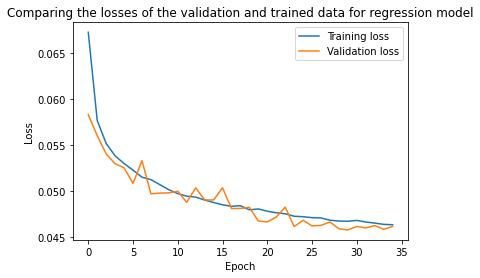

In [ ]:
plt.figure()
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.title("Comparing the losses of the validation and trained data for regression model")


In [ ]:
test_acc, test_loss = model.evaluate([xz_test, yz_test], test_labels, verbose=2)

437/437 - 2s - loss: 0.0455 - mse: 0.0449


I would have liked to plot the train data against the model's predictions, however since the dependent variable is 2D (xz and yz images, as opposed to 1D data points) I could not do so. The model succeeded in learning as the loss and MSE decreased steadily. 

# **Task 6:** Interaction mode classifier

In [ ]:
task = 6
train_images, train_labels = train_extractor(15)
test_images, test_labels = test_extractor(11,2)


In [ ]:
xz_train, yz_train  = image_separator(train_images)
xz_test, yz_test = image_separator(test_images)

In [ ]:
# converts labels to categorical (0 to 4) from binary
# need to be careful to run this cell only once otherwise it will  
# keep adding extra dimensions
train_labels = tf.keras.utils.to_categorical(train_labels, 5)
test_labels = tf.keras.utils.to_categorical(test_labels, 5)


In [ ]:
xz_input = Input(shape=(100,80,1))
xz_model = feature_extractor(xz_input) # featur#e extractor for xz images
yz_input = Input(shape=(100,80,1))
yz_model = feature_extractor(yz_input) # feature extractor for yz images

conv = concatenate([xz_model, yz_model])
dense = Dense(8, activation='relu')(conv)
dense = Dense(32, activation='relu')(dense)
dense = Dropout(0.5)(dense)
output = Dense(5, activation='softmax')(dense)
model = Model(inputs=[xz_input, yz_input], outputs=[output])

# summarize layers
#print(model.summary())
# plot model
#plot_model(model, to_file='convolutional_neural_network.png')

In [ ]:
                                  
keras.backend.clear_session()

model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
history = model.fit([xz_train,yz_train], train_labels, epochs=100, 
                    validation_split=0.2,shuffle=True, batch_size=256, 
                    callbacks=[early_stop])

Epoch 1/100
47/47 [==============================] - 4s 66ms/step - loss: 1.9957 - accuracy: 0.2138 - val_loss: 1.6130 - val_accuracy: 0.2136
Epoch 2/100
47/47 [==============================] - 3s 60ms/step - loss: 1.6254 - accuracy: 0.1967 - val_loss: 1.6128 - val_accuracy: 0.2122
Epoch 3/100
47/47 [==============================] - 3s 59ms/step - loss: 1.6144 - accuracy: 0.2029 - val_loss: 1.6133 - val_accuracy: 0.2058
Epoch 4/100
47/47 [==============================] - 3s 59ms/step - loss: 1.6090 - accuracy: 0.2105 - val_loss: 1.6093 - val_accuracy: 0.2156
Epoch 5/100
47/47 [==============================] - 3s 59ms/step - loss: 1.5977 - accuracy: 0.2284 - val_loss: 1.5954 - val_accuracy: 0.2584
Epoch 6/100
47/47 [==============================] - 3s 59ms/step - loss: 1.5870 - accuracy: 0.2480 - val_loss: 1.5692 - val_accuracy: 0.2959
Epoch 7/100
47/47 [==============================] - 3s 60ms/step - loss: 1.5749 - accuracy: 0.2596 - val_loss: 1.5539 - val_accuracy: 0.2976
Epoch 

Text(0.5, 1.0, 'Comparing the losses for interaction mode classifier')

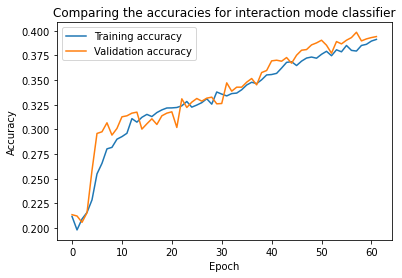

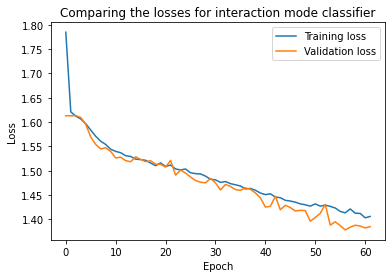

In [ ]:
# we plot the accuracies of the trained model 
# on the same graph as the test data accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.title("Comparing the accuracies for interaction mode classifier")
plt.figure()
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.title("Comparing the losses for interaction mode classifier")


The model's performance was very poor, possibly due to plenty of NC interactions or insufficient data. The model definitely learned, however it is very unlikely that it would produce any meaningful results on any test data, given the final accuracy of ~40%